# Processamento Digital de Imagens

1001527 - Turma A

Prof. Cesar Henrique Comin

## Cálculo da curvatura ao longo do contorno

### Equipe
Igor Teixeira Machado RA: 769708

Rafael Vinícius Passador RA: 790036

## Instalações Necessárias

* pip install numpy
* python -m pip install -U matplotlib

In [178]:
import numpy as np
import matplotlib.pyplot as plt

In [179]:
def correlation(img, w):

    num_rows, num_cols = img.shape
    num_rows_f, num_cols_f = w.shape      # num_rows_f=a+1 e num_cols_f=b+1 (a e b na fórmula acima)

    half_num_rows_f = num_rows_f//2       # O operador // retorna a parte inteira da divisão
    half_num_cols_f = num_cols_f//2

    # Cria imagem com zeros ao redor da borda
    img_padded = np.zeros((num_rows + 2 * half_num_rows_f, num_cols + 2 * half_num_cols_f), dtype=img.dtype)
    for row in range(num_rows):
        for col in range(num_cols):   
            img_padded[row + half_num_rows_f, col + half_num_cols_f] = img[row, col]
    # A estrutura for aninhada acima pode ser substituída por
    #img_padded = np.pad(img, ((half_num_rows_f,half_num_rows_f),(half_num_cols_f,half_num_cols_f)), mode='constant')
    
    img_filtered = np.zeros((num_rows, num_cols))
    
    for row in range(num_rows):
        for col in range(num_cols):
            sum_region = 0
            for s in range(num_rows_f):
                for t in range(num_cols_f):
                    # O índice do array na soma abaixo é diferente do utilizado na fórmula da 
                    # correlação porque estamos utilizando a imagem preenchida com zeros. O 
                    # pixel (0,0)  na imagem preenchida corresponde ao pixel (x+s-a/2, y+t-b/2) 
                    # da imagem original
                    sum_region += w[s, t] * img_padded[row + s, col + t]
            img_filtered[row, col] = sum_region

            # O loop aninhado acima pode ser substituído por
            # patch = img_padded[row:row+num_rows_f, col:col+num_cols_f]
            # img_filtered[row, col] = np.sum(w*patch)
            
    return img_filtered

def convolution(img, w):

    # Inverte o filtro
    w_inv = w[::-1, ::-1]

    img_filtered = correlation(img, w_inv)

    return img_filtered

def image_contour(img):
    '''Obtém o contorno paramétrico de um objeto contido
       no array img.'''
    
    # Mapeamento utilizado para encontrar o vizinho inicial a ser
    # buscado na próxima iteração dado o vizinho do ponto atual
    # Por exemplo, se o ponto atual for (12, 15) e o próximo ponto
    # de borda for (12, 16), isso significa que o vizinho de índice
    # 2 será o próximo ponto de borda. Nesse novo ponto, precisamos
    # buscar a partir do vizinho de índice 1, pois o vizinho de
    # índice 0 foi o último ponto a ser verificado antes de encontrarmos
    # o ponto atual
    neighbor_map = [7, 7, 1, 1, 3, 3, 5, 5]
    
    # Adiciona 0 ao redor da imagem para evitar pontos 
    # do objeto tocando a borda
    img_pad = np.pad(img, 1, mode='constant')
    
    num_rows, num_cols = img_pad.shape
    k = 0
    row = 0
    col = 0

    # Busca do primeiro ponto do objeto
    while img_pad[row, col] == 0:
        k += 1
        row = k // num_cols
        col = k - row * num_cols
        
    curr_point = (row, col)    # Ponto atual
    contour = [curr_point]     # Pontos do contorno
    starting_index = 2         # Índice do vizinho inicial a ser verificado

    while True:
        next_point, last_index = get_next_point(img_pad, curr_point, 
                                                    starting_index)

        # Novo índice do vizinho inicial baseado no último
        # índice buscado
        starting_index = neighbor_map[last_index]
        
        # Critério de parada. Se o ponto adicionado na iteração anterior (contour[-1])
        # for o mesmo que o primeiro ponto (contour[0]) e o ponto atual for o mesmo
        # que o segundo ponto adicionado, o algoritmo termina. Só podemos fazer essa
        # verificação se o contorno possuir ao menos 2 pontos. Ou seja, nosso algoritmo
        # não está tratando o caso de um objeto com apenas 1 pixel
        if len(contour) > 1:
            if next_point == contour[1] and contour[-1] == contour[0]:
                break
                
        contour.append(next_point)
        curr_point = next_point
        
    # Subtrai 1 de cada ponto pois o contorno foi encontrado para a
    # imagem preenchida com 0 na borda
    for point_index, point in enumerate(contour):
        contour[point_index] = (point[0] - 1, point[1] - 1)
        
    return contour

def get_next_point(img, curr_point, starting_index):
    '''Encontra o próximo ponto de borda dado um ponto
       corrente curr_point e o índice do primeiro vizinho
       a ser verificado (starting_index)'''
     
    # Lista dos pontos vizinhos dado o índice do vizinho
    nei_list = [(-1,0), (-1,1), (0,1), (1,1), 
                (1,0), (1,-1), (0,-1), (-1,-1)]
    
    curr_index = starting_index
    nei_value = 0

    while nei_value == 0:
        nei_shift = nei_list[curr_index]
        nei_row = curr_point[0] + nei_shift[0]
        nei_col = curr_point[1] + nei_shift[1]
        nei_value = img[nei_row, nei_col]

        if nei_value == 1:
            return (nei_row, nei_col), curr_index
        else:
            curr_index = (curr_index + 1) % 8

def gaussian_filter_2d(filter_size):
    sigma = filter_size/6.
    x_vals = np.linspace(-3*sigma, 3*sigma, filter_size)
    y_vals = x_vals.copy()
    z = np.zeros((filter_size, filter_size))

    for row in range(filter_size):
        x = x_vals[row]
        for col in range(filter_size):
            y = y_vals[col]
            z[row, col] = np.exp(-(x**2+y**2)/(2*sigma**2))
    z = z/np.sum(z)

    return z

def threshold_otsu(img):
    '''Calcula o limiar de Otsu utilizando o histograma da imagem'''
    
    bins = range(0, 257)
    hist, _ = np.histogram(img, bins)
    
    num_pixels = img.shape[0] * img.shape[1] 
    sum_img = np.sum(img)
    m_G = sum_img / num_pixels
    max_sigma_I = -1
    
    sigma_vals = np.zeros(256)
    sum_back = 0
    num_back = 0

    for threshold in range(0, 256):
        num_back = num_back + hist[threshold]  # Número de pixels com valor menor que threshold
        sum_back = sum_back + threshold * hist[threshold]  # Soma dos valores de pixel background

        num_fore = num_pixels - num_back
        sum_fore = sum_img - sum_back
        
        if num_back == 0 or num_fore == 0:
            continue
        
        P_back = num_back / num_pixels
        P_fore = num_fore / num_pixels
        m_back = sum_back / num_back   
        m_fore = sum_fore / num_fore    
        
        sigma_I = P_back * (m_back-m_G)**2 + P_fore * (m_fore-m_G)**2
        sigma_vals[threshold] = sigma_I
        
        if sigma_I > max_sigma_I:
            max_sigma_I = sigma_I
            best_threshold = threshold
    
    return best_threshold

def curvature(contour):

    x = contour[:, 0]
    y = contour[:, 1]

    dx = np.gradient(x)
    dy = np.gradient(y)

    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    curvature = (dx * ddy - ddx * dy) / (dx**2 + dy**2)**(3/2)

    return curvature

def reduce_dimension(img):
    
    if img.ndim == 3:
        img = img[:, :, 0]
        
    return img

def get_contour_and_plot(img, is_white_background, use_gaussian_filter):

    plt.figure()
    plt.title('Original')
    plt.imshow(img, cmap='gray')

    img = reduce_dimension(img)
    
    filtro = gaussian_filter_2d(6)
    img_filtrada = convolution(img, filtro)

    threshold = threshold_otsu(img_filtrada if use_gaussian_filter else img)

    img_binaria = np.zeros(img_filtrada.shape)
    if is_white_background:
        img_binaria = img_filtrada < threshold
    else:
        img_binaria = img_filtrada >= threshold

    #img_binaria = img_filtrada >= threshold
    plt.figure()
    plt.title('Binarizada')
    plt.imshow(img_binaria, cmap='gray')

    img_binaria = (img_binaria > 0).astype(np.uint8)
    img_contour = image_contour(img_binaria)
    img_contour = np.array(img_contour)
    plt.figure()
    plt.title('Contorno')
    plt.subplot(111, aspect='equal')
    plt.plot(img_contour[:, 1], img.shape[0] - img_contour[:, 0])
    plt.show()

    img_curvature = curvature(img_contour)

    plt.figure(figsize=[15,6])
    plt.plot(range(0, len(img_curvature)), img_curvature)
    plt.title('Curvatura')

    plt.show()

In [180]:
# ignorando os warnings de divisao por zero, pois o valor da derivada é 0 para os pixels adjacentes a borda da imagem
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

UnboundLocalError: local variable 'img_filtrada' referenced before assignment

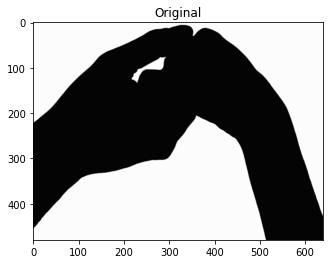

In [181]:
handsmat = plt.imread('Fotos/handsmat.tif')

get_contour_and_plot(handsmat, True, False)

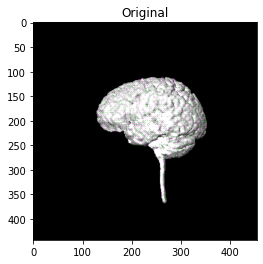

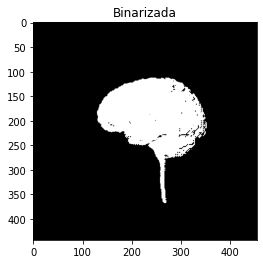

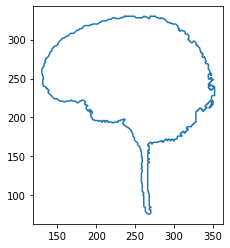

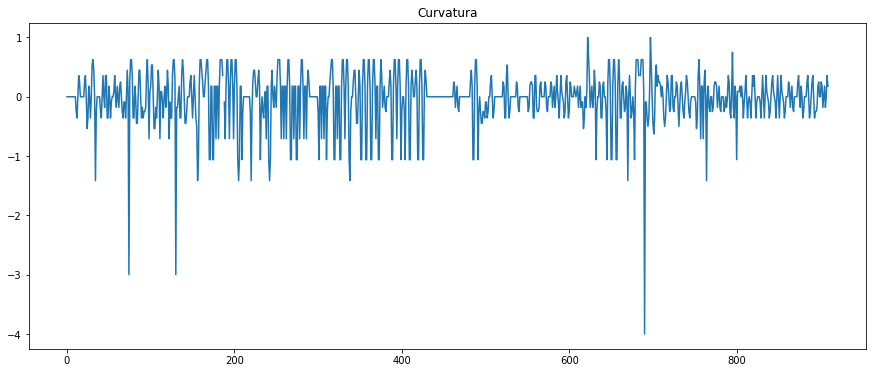

In [ ]:
brain = plt.imread('Fotos/brain.tif')

get_contour_and_plot(brain, False, True)

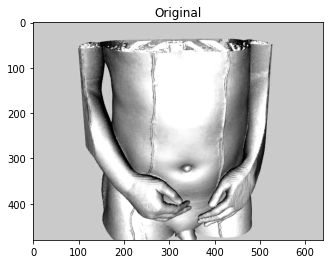

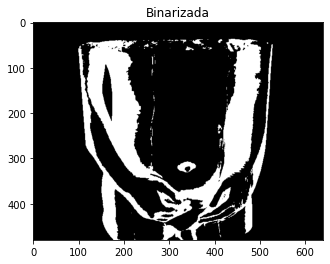

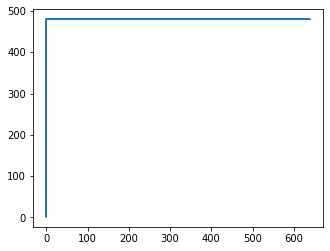

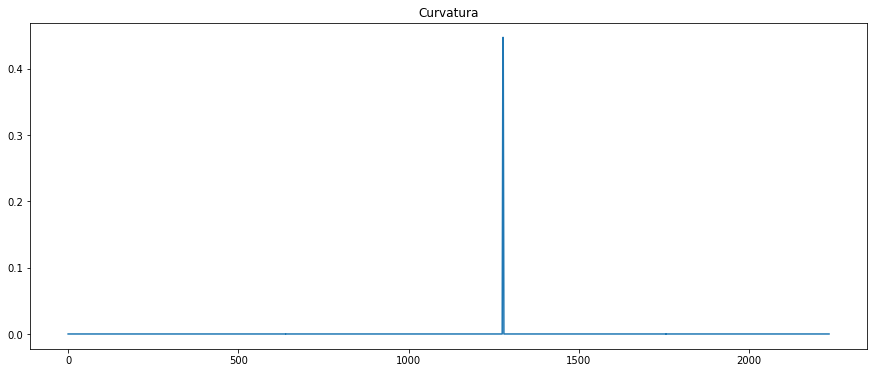

In [ ]:
body1 = plt.imread('Fotos/body1.tif')
get_contour_and_plot(body1, False, True)

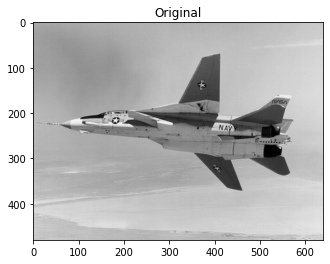

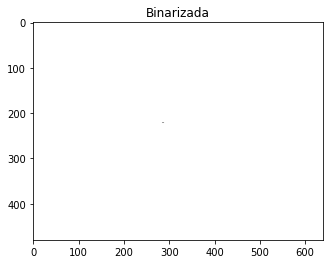

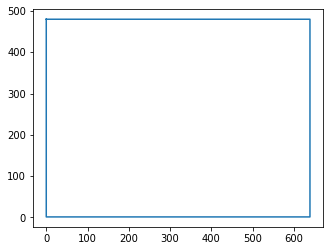

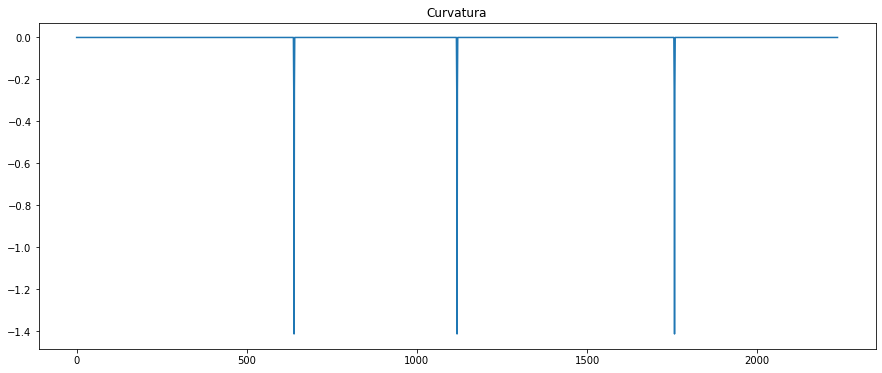

In [ ]:
f14 = plt.imread('Fotos/f14.tif')
get_contour_and_plot(f14, True, False)

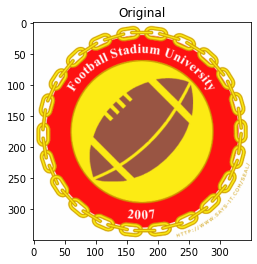

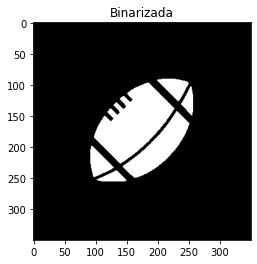

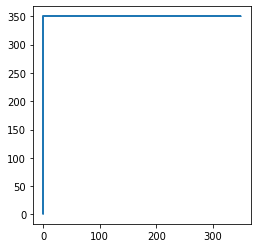

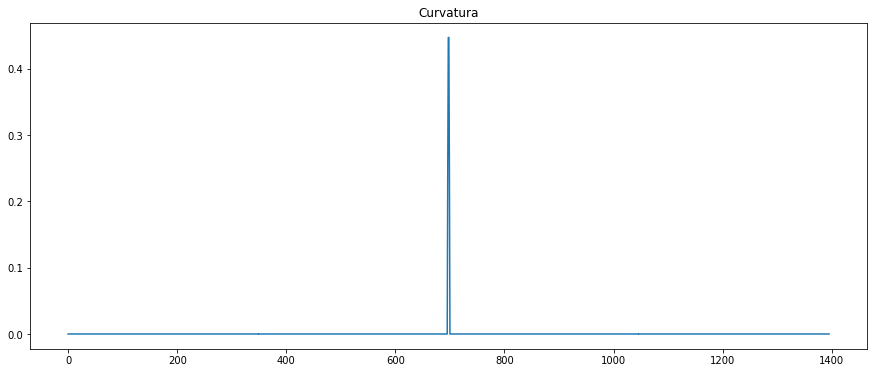

In [ ]:
football_seal = plt.imread('Fotos/football_seal.tif')
get_contour_and_plot(football_seal, True, False)